In [17]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.crs as ccrs
from cartopy.io import shapereader
import cartopy.feature as cfeature

from shapely.geometry import Polygon
from datetime import datetime

In [18]:
# Open all .nc files into an xarray database, creating a new index where the start year of each season is
# used for each level in the single dataset.

ds = xr.open_mfdataset(f'data/*.nc',
                        concat_dim=[pd.Index(np.arange(16)+2008, name="Start_Season")], combine = 'nested')

In [25]:
# Averaging snowfall over the period of record and interpolating any missing data points,
# mainly for areas right along the water.

ds_mean = ds.mean(dim='Start_Season')
ds_mean = ds_mean.sel(lon=slice(-126,-116), lat=slice(50,45))
ds_mean = ds_mean.Data.interpolate_na(dim = 'lon', method='linear', fill_value = 'extrapolate')

In [20]:
grid_lats = ds_mean.lat.values
grid_lons = ds_mean.lon.values

data = ds_mean.values # Pulling data into a 2d array.

data = data*39.37 # Converting units from meters to inches.
data_min = np.nanmin(data)
data_max = np.nanmax(data)

In [21]:
# Creates a colormap similar to the default SNODAS color table.

color_bounds = np.array([0,1,2,3,4,5,6,7,8,9,
                         10,11,12,14,16,18,20,22,24,36,48,72,96,
                         120,180,240,360,480,800])

custom_cmap_colors = ['#bdd7e7','#bdd7e7','#bdd7e7', '#6aaed6', '#6aaed6', '#6aaed6','#4491C5',
                      '#08519c','#092694', #blues
                      '#ffff96', '#FFD834', #Yellows
                      '#ffc403', '#FF9B01','#ff8700', '#F36100', #Oranges
                      '#E73B00','#db1500', '#C70E00', '#B20801', 
                      '#9e0101', '#7B0000','#690000', #Reds
                      '#ccccff', '#AEA1E5',
                      '#9f8cd8','#7c52a5', '#561c72', '#2e0033', '#41dfff']


custom_cmap = ListedColormap(custom_cmap_colors)
norm = BoundaryNorm(color_bounds, custom_cmap.N)

In [22]:
# Accessing road shapefiles, setting coordinate system, and subsetting for major roads.

wa_roads_file = gpd.read_file("http://www2.census.gov/geo/tiger/TIGER2020/PRISECROADS/tl_2020_53_prisecroads.zip")
or_roads_file = gpd.read_file("http://www2.census.gov/geo/tiger/TIGER2020/PRISECROADS/tl_2020_41_prisecroads.zip")

wa_roads_file_crs = wa_roads_file.to_crs(epsg = 4326)
or_roads_file_crs = or_roads_file.to_crs(epsg = 4326)

wa_state_roads = wa_roads_file_crs[wa_roads_file_crs.RTTYP == "S"]
wa_interstates = wa_roads_file_crs[wa_roads_file_crs.RTTYP == "I"]
wa_us_roads = wa_roads_file_crs[wa_roads_file_crs.RTTYP == "U"]

or_state_roads = or_roads_file_crs[or_roads_file_crs.RTTYP == "S"]
or_interstates = or_roads_file_crs[or_roads_file_crs.RTTYP == "I"]
or_us_roads = or_roads_file_crs[or_roads_file_crs.RTTYP == "U"]

In [23]:
## Creating a mask to keep data contours only visible in the US.

def rect_from_bound(xmin, xmax, ymin, ymax):
    
    xs = [xmax, xmin, xmin, xmax, xmax]
    ys = [ymax, ymax, ymin, ymin, ymax]
    return [(x, y) for x, y in zip(xs, ys)]
    
shpfilename = shapereader.natural_earth('10m','cultural','admin_0_countries')

df = gpd.read_file(shpfilename)

poly = [df.loc[df['ADMIN'] == 'United States of America']['geometry'].values[0]]

ll_proj = ccrs.PlateCarree()

pad1 = 0.1
exts = [poly[0].bounds[0] - pad1, poly[0].bounds[2] + pad1, poly[0].bounds[1] - pad1, poly[0].bounds[3] + pad1]

msk = Polygon(rect_from_bound(*exts)).difference( poly[0].simplify(0.01))

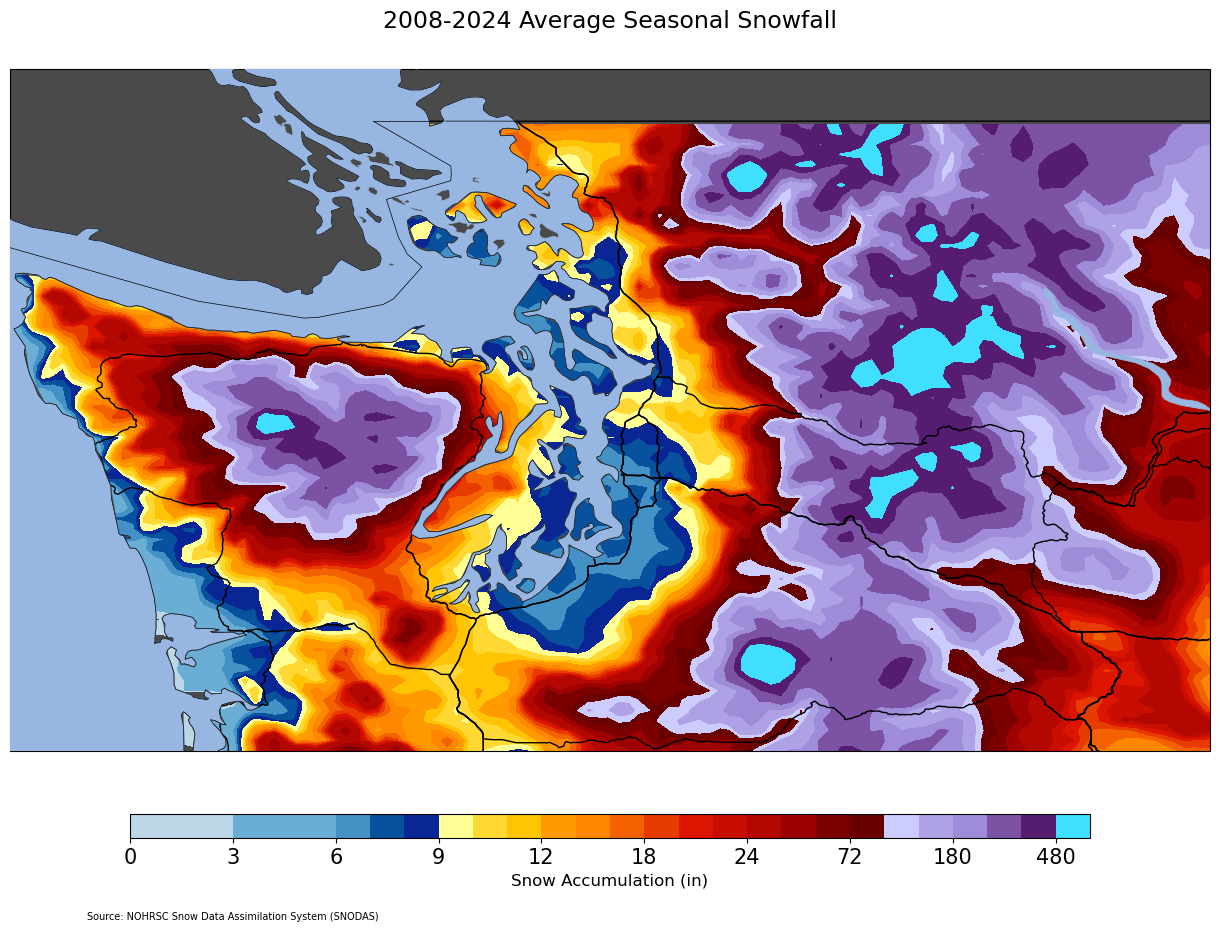

In [24]:
vmin = color_bounds.min()
vmax = color_bounds.max()

# Set Map Bounds
minLat = 46.5
maxLat = 49.2
minLon = -124.75
maxLon = -120

cm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
cm.set_array(np.array(data))
cm.set_clim(vmin, vmax)


fig= plt.figure(num=1, figsize=(12,8), dpi=100, facecolor='w', edgecolor='k')

ax = fig.add_axes([0, 0, 1, 1], projection= ccrs.PlateCarree())
ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())

ax.set_facecolor('#4a4a4a')

# Add Boundaries
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.BORDERS,linewidth=0.5, zorder=6)
ax.add_feature(cfeature.STATES,linewidth=0.5, zorder=7)
ax.add_feature(cfeature.OCEAN,linewidth=0.5, zorder=5)
ax.add_feature(cfeature.LAKES,linewidth=0.5)

## Add roads

ax.add_geometries(wa_interstates.geometry, crs = ccrs.PlateCarree(), facecolor='none', edgecolor='k')
ax.add_geometries(wa_us_roads.geometry, crs = ccrs.PlateCarree(), facecolor='none', edgecolor='k')

# Add U.S Mask
ax.add_geometries([msk], crs = ccrs.PlateCarree(), zorder=2, facecolor='#4a4a4a', edgecolor='none')

# Average Snowfall Contours
ax.contourf(grid_lons,grid_lats,data,color_bounds, transform=ccrs.PlateCarree(), cmap=custom_cmap, norm=norm)


# Add Colorbar
cax = fig.add_axes([0.1, -0.035, 0.8, 0.03])
cbar=plt.colorbar(cm, cax=cax,boundaries=color_bounds,orientation='horizontal',extend='both',spacing='uniform')
cbar=plt.colorbar(cm, cax=cax,boundaries=color_bounds,orientation='horizontal',spacing='uniform')
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Snow Accumulation (in)',size=12)


plt.annotate('Source: NOHRSC Snow Data Assimilation System (SNODAS)',xy=(-0.045, -3.51), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='left', verticalalignment='bottom')
plt.suptitle('2008-2024 Average Seasonal Snowfall',size=17,color='black',y=1.00) 

plt.savefig('2008-2024_Average_Snowfall.png', bbox_inches='tight')
plt.show() 
plt.clf()
plt.close()